In [2]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33856 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:40662 Dashboard: http://127.0.0.1:33856/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [3]:
import numpy as np
import xarray as xr
import qgutils
import os.path as op
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
U = .1
nl = 3
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1563.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

In [5]:
ddir = '/store/CT1/hmg2840/tuchida/msqg-diags/seas-forcing/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/qg-ensemble/'
store = '/store/tuchida/msqg-diags/seas-forcing/ctrl/10percent/Fr-sqrt3_Ekb-2/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [6]:
ds = xr.open_dataset(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000.nc'))
ds

<xarray.Dataset>
Dimensions:  (t: 623, x: 256, y: 256, z: 3)
Coordinates:
  * y        (y) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * x        (x) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * z        (z) float32 0.0 1.0 2.0
  * t        (t) float32 0.0 1.0 2.0 3.0 4.0 ... 618.0 619.0 620.0 621.0 622.0
Data variables:
    p        (t, z, y, x) float32 ...
    q        (t, z, y, x) float32 ...
    ptr0     (t, z, y, x) float32 ...
    ptr1     (t, z, y, x) float32 ...

In [7]:
psi = xr.DataArray(qgutils.pad_bc(ds.p.isel(t=-1)), dims=['z','y','x'],
                   coords={'z':ds.z.data,'y':range(-1,N+1),'x':range(-1,N+1)})
psi_doub = psi.interp({'y':np.arange(-.25,N-.25,.5),'x':np.arange(-.25,N-.25,.5)})
psi_doub

<xarray.DataArray (z: 3, y: 512, x: 512)>
array([[[ 1.23615777e-02,  3.48559697e-02,  5.51215983e-02, ...,
         -7.26353761e-07, -1.13101211e-06, -6.66670644e-07],
        [ 3.57370954e-02,  1.00591360e-01,  1.58825697e-01, ...,
          4.44220973e-07, -1.79182609e-06, -1.45492481e-06],
        [ 5.77649754e-02,  1.62350200e-01,  2.55990699e-01, ...,
          4.23807796e-06, -8.51429832e-07, -1.69809186e-06],
        ...,
        [-6.20932784e-02, -1.70767341e-01, -2.63928909e-01, ...,
         -2.69164549e-04, -1.54285092e-04, -4.84226821e-05],
        [-3.83519698e-02, -1.05455477e-01, -1.62958551e-01, ...,
         -1.59448825e-04, -9.13182366e-05, -2.86264712e-05],
        [-1.32406568e-02, -3.63997710e-02, -5.62366857e-02, ...,
         -5.22954815e-05, -2.99174044e-05, -9.36418292e-06]],

       [[-3.44821252e-04, -8.08604440e-04, -1.04652831e-03, ...,
         -7.02155597e-06, -4.81871513e-06, -1.85864735e-06],
        [-1.93590589e-03, -4.92160977e-03, -7.02120573e-03, ...,
         -2.10277111e-05, -1.44330030e-05, -5.56782447e-06],
        [-4.42843267e-03, -1.15304115e-02, -1.68775039e-02, ...,
         -3.49969094e-05, -2.40241485e-05, -9.26888401e-06],
...
        [ 3.55694527e-02,  9.62694152e-02,  1.46530435e-01, ...,
         -2.26656281e-04, -1.29123396e-04, -4.01784764e-05],
        [ 2.07477091e-02,  5.61243375e-02,  8.53821761e-02, ...,
         -1.36011938e-04, -7.74832233e-05, -2.41094331e-05],
        [ 6.66841911e-03,  1.80259009e-02,  2.74040264e-02, ...,
         -4.53448861e-05, -2.58315708e-05, -8.03745661e-06]],

       [[-2.11738120e-03, -5.77003241e-03, -8.84057244e-03, ...,
         -6.60030071e-06, -4.52312099e-06, -1.74226557e-06],
        [-6.25262829e-03, -1.70340992e-02, -2.60917845e-02, ...,
         -1.98091132e-05, -1.35728578e-05, -5.22736502e-06],
        [-1.02883601e-02, -2.80221680e-02, -4.29130637e-02, ...,
         -3.30261368e-05, -2.26260893e-05, -8.71303280e-06],
        ...,
        [ 2.02745493e-02,  5.53649908e-02,  8.49967755e-02, ...,
         -2.22287657e-04, -1.26636041e-04, -3.94051167e-05],
        [ 1.28840231e-02,  3.52129161e-02,  5.41026557e-02, ...,
         -1.33425401e-04, -7.60112198e-05, -2.36520646e-05],
        [ 4.59438004e-03,  1.25684394e-02,  1.93277979e-02, ...,
         -4.44971333e-05, -2.53494022e-05, -7.88776833e-06]]])
Coordinates:
  * z        (z) float32 0.0 1.0 2.0
  * y        (y) float64 -0.25 0.25 0.75 1.25 1.75 ... 253.8 254.2 254.8 255.2
  * x        (x) float64 -0.25 0.25 0.75 1.25 1.75 ... 253.8 254.2 254.8 255.2

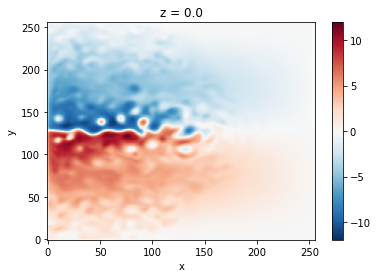

In [25]:
psi_doub.isel(z=0).plot()

In [16]:
Nz, Ny, Nx = psi_doub.shape
p_bas = np.zeros((Nz,Ny+1,Nx+1))
p_bas[:,1:,1:] = psi_doub.data
p_bas[:,0,0] = Ny
p_bas = np.transpose(p_bas, (0,2,1))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
p_bas.astype('f4').tofile(scratch+'initial-cond/p0_from-N256.bas')

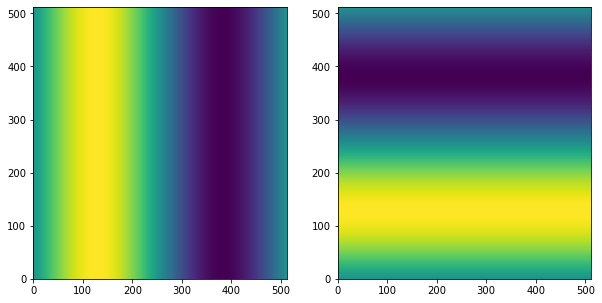

In [8]:
# Delta = 1/N
x = np.linspace(-1.,1.,N*2)
sin = np.sin(2*np.pi*np.linspace(0,1,N*2))

ptr0 = np.zeros((nl,N*2,N*2))
ptr0 += x[np.newaxis,np.newaxis,:]

ptr1 = np.zeros((nl,N*2,N*2))
ptr1 += x[np.newaxis,:,np.newaxis]

ptr2 = np.zeros((nl,N*2,N*2))
ptr2 += sin[np.newaxis,np.newaxis,:]

ptr3 = np.zeros((nl,N*2,N*2))
ptr3 += sin[np.newaxis,:,np.newaxis]

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.pcolormesh(ptr2[0])
ax2.pcolormesh(ptr3[0])

In [9]:
nptr = 4
ptr = np.zeros((nl*nptr,N*2+1,N*2+1))
ptr[:,0,0] = N*2
ptr[0::nptr,1:,1:] = ptr0
ptr[1::nptr,1:,1:] = ptr1
ptr[2::nptr,1:,1:] = ptr2
ptr[3::nptr,1:,1:] = ptr3
ptr = np.transpose(ptr,(0,2,1))
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_init.bas')
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_relx.bas')

# Generate perturbed initial condition

In [ ]:
ds = xr.open_dataset(op.join(store,'N512/vars.nc'))

In [ ]:
Ns,Ne = (0,100)
for i in range(Ns,Ne):
    j = np.random.randint(0,int(len(ds.x)*len(ds.y)))
    print(j)
    k = 1e-31 * np.random.standard_normal()
    p = ds.p.isel(t=-1,z=0).load().data.ravel()
    p[j] += k
    psave = xr.concat([xr.DataArray(p.reshape((1,len(ds.y),len(ds.x))), dims=['z','y','x'], 
                                    coords={'z':np.array([0.]), 'y':ds.y.data, 'x':ds.x.data}, name='p'),
                       ds.p.isel(t=-1,z=slice(1,None)).drop('t')], 
                      'z')
    if i % 10 == 0:
        print(psave)
        fig, ax = plt.subplots()
        psave.isel(z=0).plot(ax=ax, vmax=15)
        plt.show()
    
    Nz, Ny, Nx = psave.shape
    p_bas = np.zeros((Nz,Ny+1,Nx+1))
    p_bas[:,1:,1:] = psave.data
    p_bas[:,0,0] = Ny
    p_bas = np.transpose(p_bas, (0,2,1))
    p_bas.astype('f4').tofile(scratch+'initial-cond/psi-perturbed/p0-seas_%02dpercent_%03d.bas' % (percent,i))